In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from aeolus.const import init_const

In [3]:
import paths

In [4]:
const_gj1214b = init_const("camembert_gj1214b", directory=paths.const)

In [5]:
file_path = "https://raw.githubusercontent.com/projectcuisines/camembert/main/InitialConditions/CAMEMBERT_GJ1214b_IC.dat"

In [6]:
df = pd.read_csv(file_path, delimiter="\s+", comment="#")

In [7]:
df.loc[-1, 'Pressure_Pa'] = 30e5

df = df.sort_values("Pressure_Pa").reset_index(drop=True).interpolate()

df = df[df["Pressure_Pa"]<=30e5]
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)

In [8]:
p0 = df["Pressure_Pa"].values[0]

In [9]:
exner = (df["Pressure_Pa"] / p0) ** (
    const_gj1214b.dry_air_gas_constant / const_gj1214b.dry_air_spec_heat_press
).data

In [10]:
print(np.round(df["Temperature_K"], 2))

0     1013.31
1     1005.70
2      993.51
3      984.96
4      978.33
       ...   
69     469.21
70     461.55
71     452.08
72     437.88
73     407.34
Name: Temperature_K, Length: 74, dtype: float64


In [11]:
print(np.round(exner, 2))

0     1.00
1     0.96
2     0.90
3     0.84
4     0.78
      ... 
69    0.01
70    0.01
71    0.01
72    0.01
73    0.01
Name: Pressure_Pa, Length: 74, dtype: float64


In [12]:
df["Theta_K"] = df["Temperature_K"] / exner
print(np.round(df["Theta_K"], 2))

0      1013.31
1      1042.59
2      1104.08
3      1173.36
4      1249.33
        ...   
69    54872.49
70    57861.51
71    60752.45
72    63078.76
73    62902.85
Name: Theta_K, Length: 74, dtype: float64


(200.0, 1450.0)

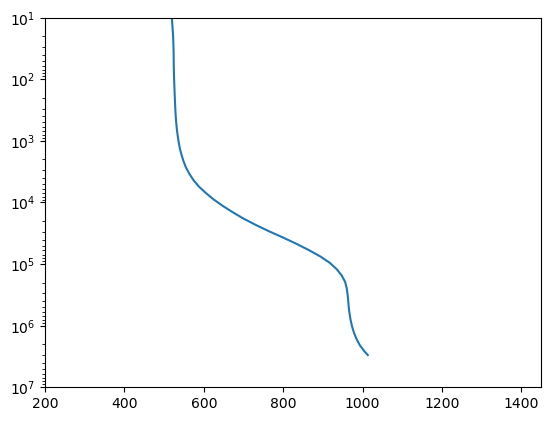

In [13]:
plt.plot(df["Temperature_K"], df["Pressure_Pa"])
# plt.plot(df["Temperature_K"].values[73], df["Pressure_Pa"].values[73], marker="o")

plt.yscale("log")
plt.ylim(1e7, 1e1)
plt.xlim(200, 1450)

In [14]:
temp = df["Temperature_K"].values
pres = df["Pressure_Pa"].values


z = np.zeros(df.shape[0])
for i in range(1, z.shape[0]):
    scale_height = const_gj1214b.dry_air_gas_constant.data * temp[i-1] / const_gj1214b.gravity.data
    z[i] = z[i-1] - scale_height * np.log(pres[i] / pres[i-1])

In [15]:
np.round(z/1e6, 2)

array([0.  , 0.04, 0.12, 0.2 , 0.27, 0.35, 0.43, 0.5 , 0.58, 0.65, 0.73,
       0.8 , 0.88, 0.95, 1.03, 1.1 , 1.17, 1.24, 1.31, 1.37, 1.43, 1.49,
       1.55, 1.6 , 1.66, 1.71, 1.76, 1.8 , 1.85, 1.89, 1.94, 1.98, 2.02,
       2.07, 2.11, 2.15, 2.19, 2.23, 2.27, 2.32, 2.36, 2.4 , 2.44, 2.48,
       2.52, 2.56, 2.6 , 2.64, 2.68, 2.73, 2.77, 2.81, 2.85, 2.89, 2.93,
       2.97, 3.01, 3.05, 3.09, 3.13, 3.17, 3.21, 3.25, 3.29, 3.33, 3.37,
       3.4 , 3.44, 3.48, 3.52, 3.55, 3.59, 3.62, 3.66])

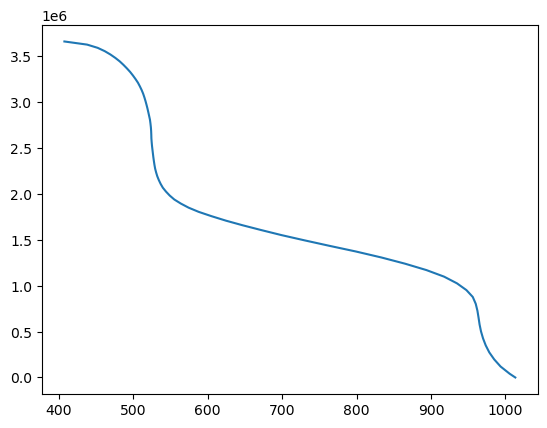

In [16]:
plt.plot(temp, z)

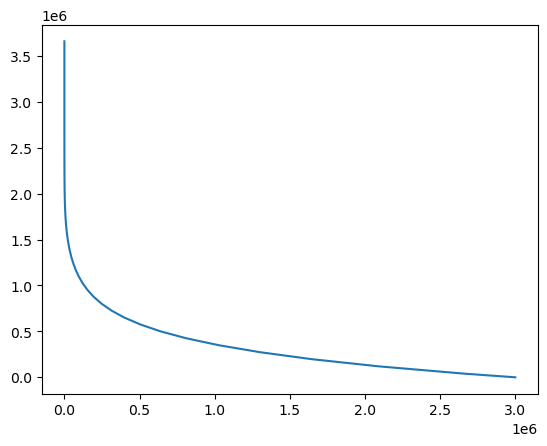

In [17]:
plt.plot(pres, z)

In [18]:
(np.diff(pres)<0).all()

True

In [19]:
df["Theta_K"].values * exner.values

array([1013.308145, 1005.69532 ,  993.506124,  984.96458 ,  978.327079,
        973.541531,  969.951696,  967.231115,  965.309386,  963.91111 ,
        962.399306,  960.142692,  956.136182,  947.627077,  934.888884,
        917.556513,  893.792086,  865.033263,  833.330863,  799.176259,
        763.307383,  729.955899,  699.073152,  672.0491  ,  646.930754,
        624.431572,  605.083952,  587.797899,  574.22644 ,  563.76001 ,
        555.059006,  548.863093,  543.871505,  539.632245,  536.650465,
        534.193693,  532.139752,  530.587615,  529.269431,  528.360519,
        527.592763,  526.888854,  526.282403,  525.682005,  525.091533,
        524.639816,  524.252143,  524.117654,  523.909175,  523.554311,
        522.992391,  522.320556,  521.227239,  520.112476,  518.974122,
        517.700092,  516.345486,  514.84724 ,  513.178027,  511.14598 ,
        508.772404,  506.194606,  502.949769,  499.455789,  495.672039,
        491.329345,  486.699124,  481.692909,  475.809826,  469.